# Notebook for testing workflow and making example plots

As of Sept 2017, 54 subjects have complete MEG data. I have yet to separate them by group or age. 
Also, no source localization yet, I'm thinking finding effects in the sensor space first and use beamforming to localize it later.

All scripts can be found here: https://github.com/kaihwang/Clock/blob/master/Clock.py

In [1]:
# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mne as mne
import os.path as op
%matplotlib inline

# to run complete pipeline
# run "indiv_subject_raw_to_tfr()", "run_group_ave_evoke()", and "run_group_ave_power()" functions in Clock.py 

------





## Workflow for inspecting individual subject data

In [67]:
#read data
raw = mne.io.read_raw_fif('/home/despoB/kaihwang/Clock/11288/MEG/11288_clock_run6_dn_ds_sss_raw.fif')


Opening raw data file /home/despoB/kaihwang/Clock/11288/MEG/11288_clock_run6_dn_ds_sss_raw.fif...
    Range : 0 ... 69999 =      0.000 ...   279.996 secs
Ready.
Current compensation grade : 0


### Plot raw TS
noticed that mageotometers much noiser... Might want to only use gradiometers?

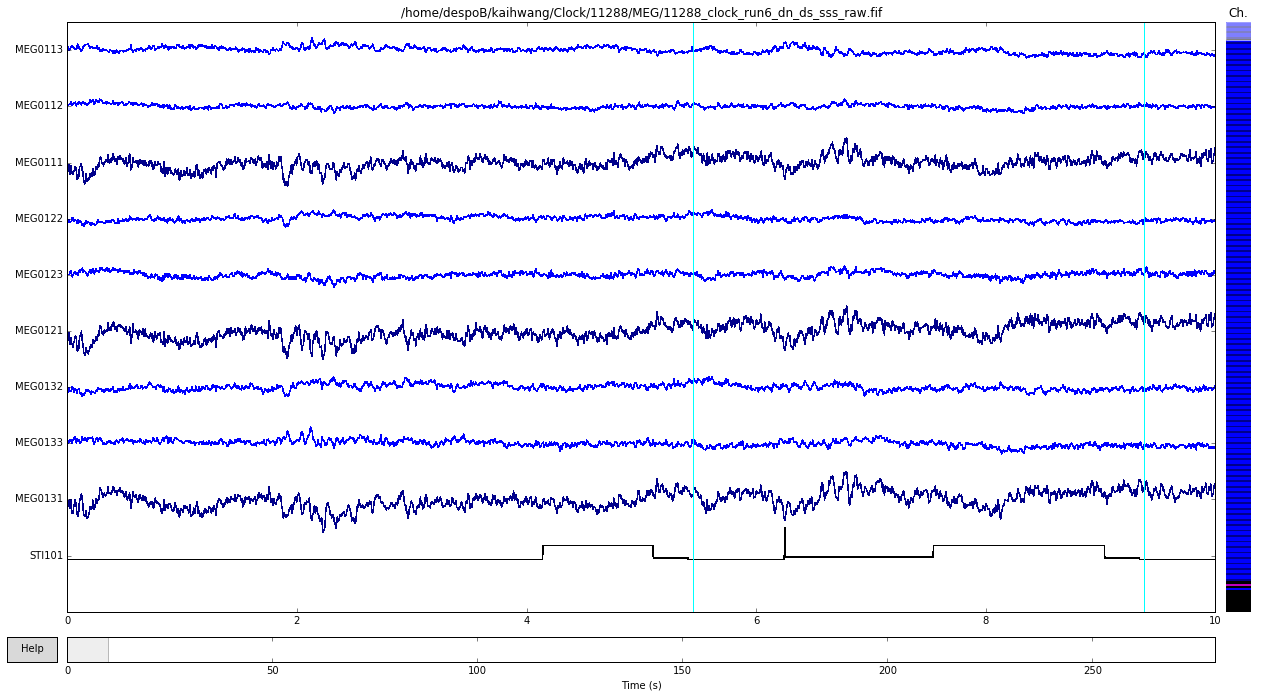

In [68]:
## examine raw
order = np.arange(raw.info['nchan'])
order[9] = 310  # We exchange the plotting order of two channels
order[310] = 9  # to show the trigger channel as the 10th channel.
#raw.plot(n_channels=10, order=order, block=True)

#mark events with raw. Notie that Mageometers much noiser
events = mne.read_events('/home/despoB/kaihwang/Clock/11288/MEG/MEG_11288_20140711_6_feedback_ds4.eve')
raw.plot(events=events, n_channels=10, order=order);

63 matching events found
0 projection items activated
Loading data for 63 events and 176 original time points ...
0 bad epochs dropped
Loading data for 20 events and 176 original time points ...


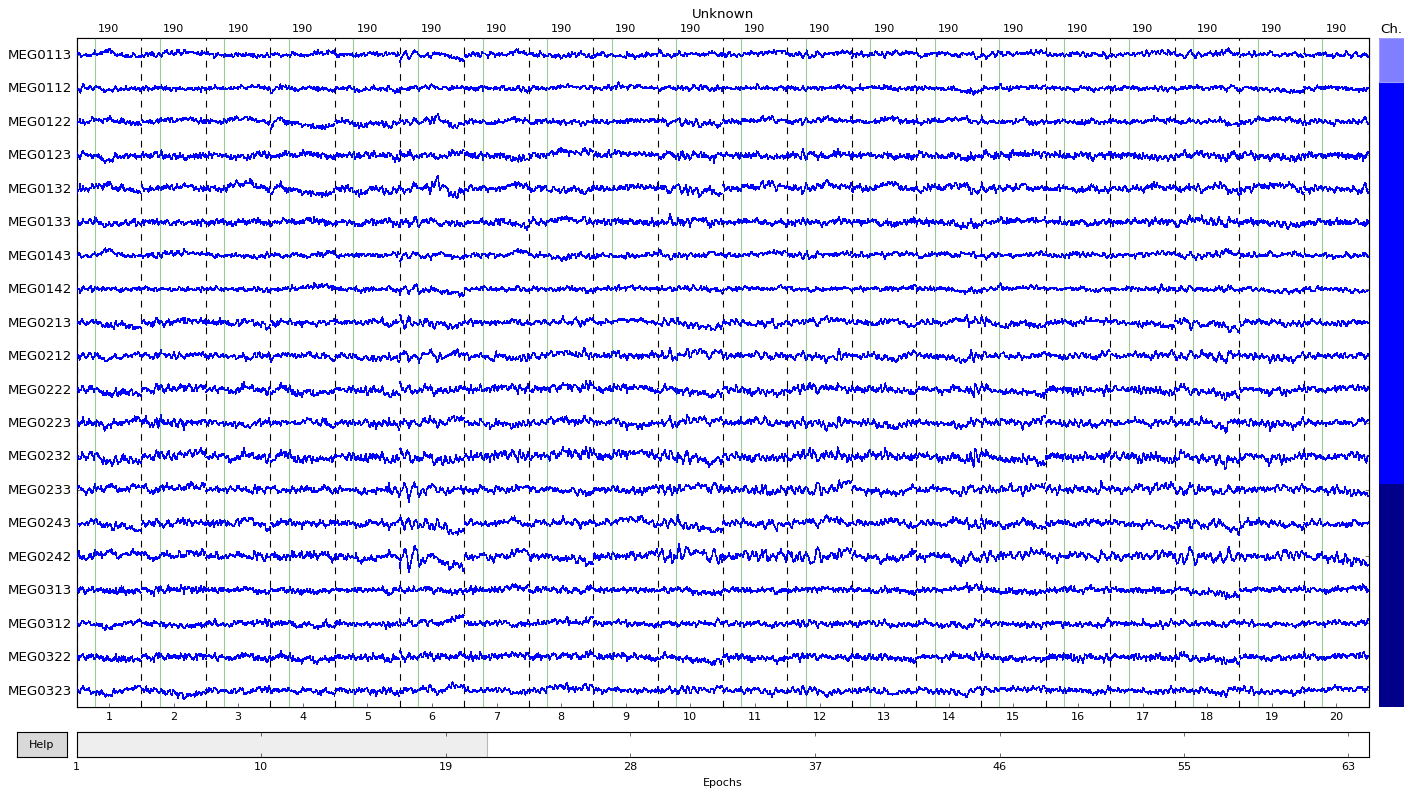

In [69]:
## test epoch function and plotting
tmin, tmax = -0.2, 0.5
event_id = {'Clock': 190}
# Only pick MEG and EOG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=False)

baseline = (None, 0.0)
reject = {'mag': 4e-11}
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, reject=reject, picks=picks)
epochs.plot(block=True);

---






# Group averaged evoked responses (time domain)

For each subject, evoked responses were extracted for clock onset, feedback onset, and response onset. Mean from the baseline period were substracted. 

In [4]:
## load average evoke response. Plot
clock_evoke = mne.read_evokeds('Data/group_clock-evoke-ave.fif');
# trials TFR time locked to response onset
RT_evoke = mne.read_evokeds('Data/group_RT-evoke-ave.fif');
# trials TFR time locked to feedback onset
feedback_evoke = mne.read_evokeds('Data/group_feedback-evoke-ave.fif');


Reading Data/group_clock-evoke-ave.fif ...
    Found the data of interest:
        t =   -1000.00 ...    4000.00 ms (0.13 * DEV.scram.face + 0.13 * IEV.happy.face + 0.13 * IEV.fear.face + 0.13 * IEV.scram.face + 0.12 * DEV.happy.face + 0.13 * DEV.fear.face + 0.13 * CEVR.scram.face + 0.13 * CEV.scram.face)
        0 CTF compensation matrices available
        nave = 54 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
Reading Data/group_RT-evoke-ave.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1152.00 ms (0.12 * IEV.happy.score + 0.12 * CEV.scram.score + 0.12 * DEV.scram.score + 0.12 * IEV.scram.score + 0.12 * CEVR.scram.score + 0.12 * DEV.fear.score + 0.12 * IEV.fear.score + 0.12 * DEV.happy.score)
        0 CTF compensation matrices available
        nave = 54 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline corr

## Evoked responses locked to clock onset

one early peak <100ms that is probably stimulus driven

two later peaks, and also sustained response which could be averaged motor response at different timepoints, though topography suggests it is posterior.  

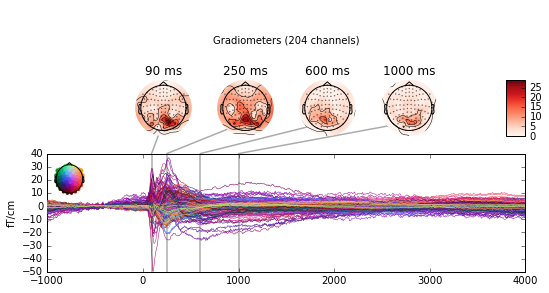

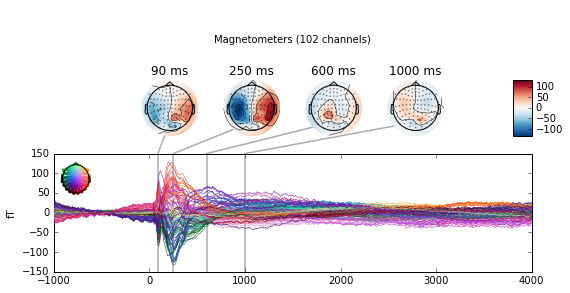

In [6]:
clock_evoke[0].plot_joint(times=[0.09, 0.25, 0.6, 1]);

## Evoked responses locked to buttom press

one early peak 80ms before buttom press, and a small peak around 0 ms. Response was at time 0.

Later effects probably related to feedback (at 300ms).

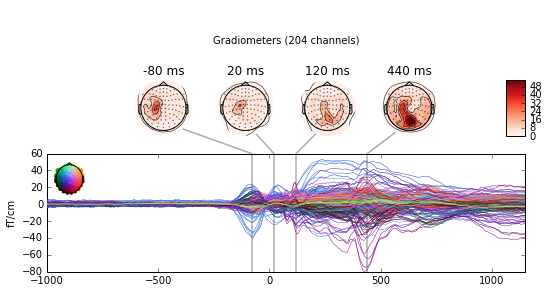

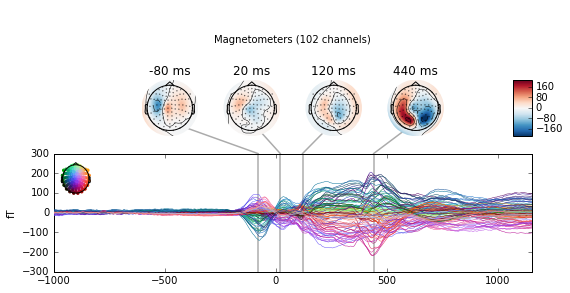

In [72]:
RT_evoke[0].plot_joint(times=[-0.08, 0.02, 0.12, 0.44]);

## Evoked responses locked to feedback onset

The first peak at -300 ms is definitely motor evoked response.

Strong effects not time-locked to feedback onset

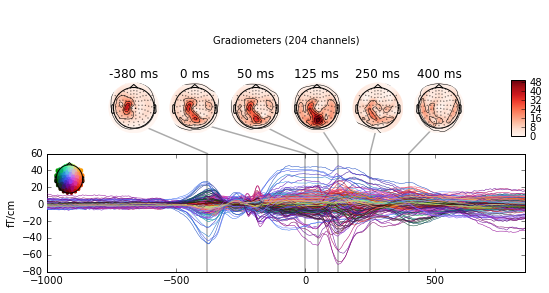

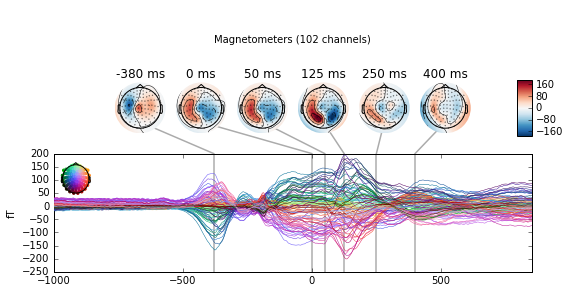

In [73]:
feedback_evoke[0].plot_joint(times=[-0.38, 0, 0.05, 0.125, 0.25, 0.4]);

---






# Group averaged oscillatory power (frequency domain)

For each subject, single trial TS timelocked to either clock onset, feedback onset, and response were extracted from each sensor. TS were then convolved with a set of wavelets to extract oscillatory power TS. Power values were then normalized to z-score using mean and sd during the ITI. Normalized power were then averaged across trials, conditions, and subjects.

Note, I have not yet separate trials by conditions (i.e., CEV/IEV, Happy/Negative ... etc). We should discuss what is the best statistic model to analyze all the relevant variables (reward function/age/emotion manipualtion). Here the goal is just to see if we could get some reasonable looking task-related signals in the frequency space.

In [7]:
# load trial types.
# trials TFR time locked to clock onset
clock_power = mne.time_frequency.read_tfrs('Data/group_clock_power-tfr.h5')
# trials TFR time locked to response onset
RT_power = mne.time_frequency.read_tfrs('Data/group_RT_power-tfr.h5')
# trials TFR time locked to feedback onset
feedback_power = mne.time_frequency.read_tfrs('Data/group_feedback_power-tfr.h5')

Reading Data/group_clock_power-tfr.h5 ...
Reading Data/group_RT_power-tfr.h5 ...
Reading Data/group_feedback_power-tfr.h5 ...


---

## Trials time-locked to clock onset
### Topology 
notice the spatial difference of front v back, left v right. 

No baseline correction applied


<IPython.core.display.Javascript object>


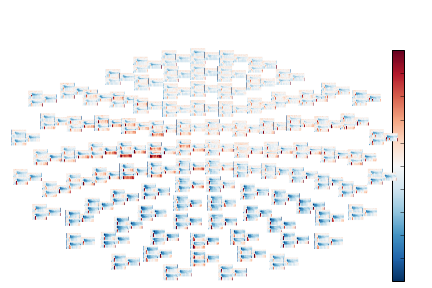

In [13]:
clock_power[0].plot_topo(mode=None, vmin=-3, vmax=3, show=True,title = "Clock");

### individual sensors
There is a sustained decrease in alpha power after clock onset. Most pronounce in posterior sensors. Could this be value signal?

A transient increase in theta right after clock onset, prob evoked response. 

No baseline correction applied


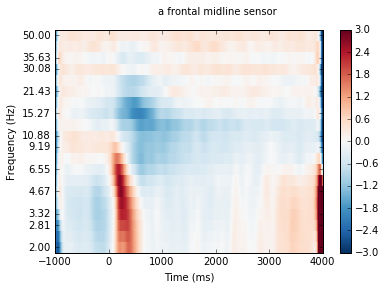

No baseline correction applied


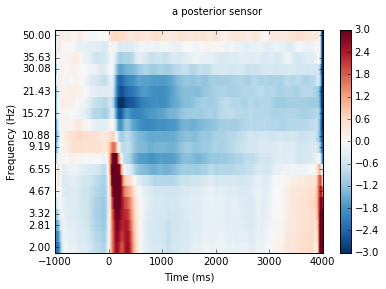

No baseline correction applied


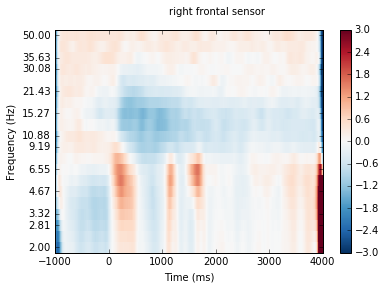

In [14]:
clock_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG0713']), vmin=-3, vmax=3, baseline=None, mode=None, title='a frontal midline sensor');
clock_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG2043']), vmin=-3, vmax=3, baseline=None, mode=None, title='a posterior sensor');
clock_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG1223']), vmin=-3, vmax=3, baseline=None, mode=None, title='right frontal sensor');

# Trials time locked to feedback
### The toplogy

---

## Trials timelocked to feedback onset
### Topology

No baseline correction applied


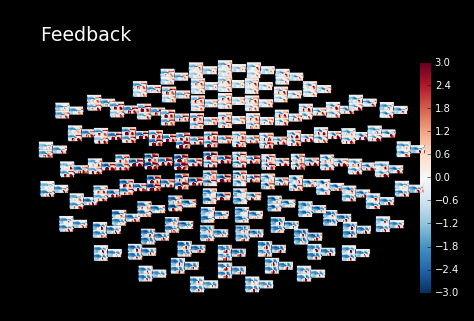

In [23]:
feedback_power[0].plot_topo(mode=None, vmin=-3, vmax=3, show=True,title = "Feedback" );

### individual sensors
Strong theta evoked response a couple hundre mil seconds before feedback onset. Probably motor-related evoked response.

Strong theta and beta response after feedback presentation, PE/feedback signal?

No baseline correction applied


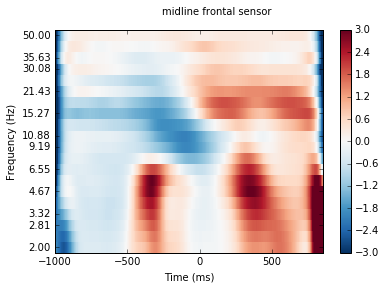

No baseline correction applied


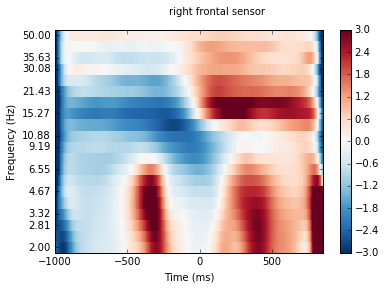

No baseline correction applied


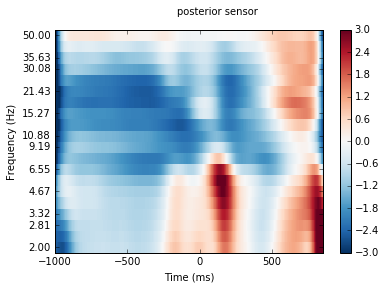

In [15]:
feedback_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG1033']), vmin=-3, vmax=3, baseline=None, mode=None, title='midline frontal sensor');
feedback_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG0713']), vmin=-3, vmax=3, baseline=None, mode=None, title='right frontal sensor');
feedback_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG2043']), vmin=-3, vmax=3, baseline=None, mode=None, title='posterior sensor');

---

## Trials locked to response
### topology
Notice the midline left vs right difference, subjects respond by right hand?

No baseline correction applied


<IPython.core.display.Javascript object>


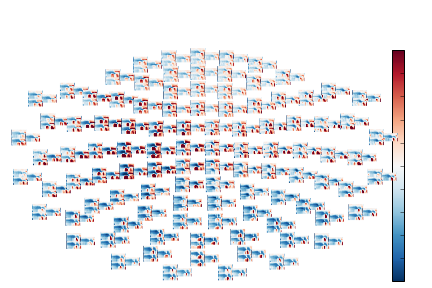

In [14]:
RT_power[0].plot_topo(mode=None, vmin=-3, vmax=3, show=True,title = "Response" );

### individual sensor
Over right motor cortex, classically looking beta dyschronization before button press, and a rebound after button press.

Motor evoked response around time 0 (buttom press)

No baseline correction applied


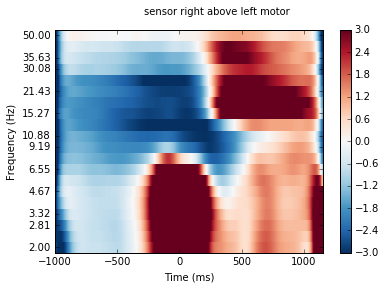

In [18]:
RT_power[0].plot(mne.pick_channels(clock_power[0].ch_names, ['MEG0433']), vmin=-3, vmax=3, baseline=None, mode=None, title = 'sensor right above left motor');